# Testing on the dataset

## Initialization

In [1]:

from datasets import load_dataset


ds = load_dataset("CharlyR/vtikz", "tikz", split="test")
ds = ds.select_columns(["id","type","instruction","code","image_solution","image_input","code_solution"])


/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from openai import OpenAI
import os
from google import genai
from google.genai import types as genTypes
from vif.falcon.edition import OracleEditionModule
from vif.falcon.falcon import Falcon
from vif.falcon.oracle.guided_oracle.guided_code_oracle import OracleGuidedCodeModule
from vif.utils.renderer.tex_renderer import TexRenderer

gclient = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
    http_options=genTypes.HttpOptions(api_version="v1alpha"),
)

oclient = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)


oracle_module = OracleGuidedCodeModule(
    model="google/gemini-2.5-flash-lite",
    temperature=0.3,
    client=oclient,
    visual_client=gclient,
    visual_generation_content_config=genTypes.GenerateContentConfig(temperature=0.3),
    visual_model="gemini-2.5-pro"
)
edition_module = OracleEditionModule(
    model="google/gemini-2.5-flash-lite",
    temperature=0.3,
    client=oclient,
)

agent = Falcon(
    code_renderer=TexRenderer().from_string_to_image,
    oracle_module=oracle_module,
    edition_module=edition_module,
    observe=True,
    observe_folder="/home/creux/Documents/AI/VIFagent/.tmp/observe",
    existing_observe_checkpoint="/home/creux/Documents/AI/VIFagent/.tmp/observe/1308-14:41:17.pickle"
)

You are trying to use a model that was created with Sentence Transformers version 5.0.0, but you're currently using version 4.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.
2025-08-13 14:41:17.877 | WARNING  | vif.falcon.falcon:__init__:57 - The observe parameter is activated, dict will be stored at /home/creux/Documents/AI/VIFagent/.tmp/observe/1308-14:41:17.pickle


#### Manual Tests on one example

In [10]:
agent.apply_instruction(ds[0]["code"],ds[0]["instruction"],ds[0]["id"])

2025-08-13 14:19:10.152 | INFO     | vif.falcon.falcon:apply_instruction:91 - Creating the oracle
2025-08-13 14:19:10.153 | INFO     | vif.falcon.oracle.guided_oracle.guided_code_oracle:get_oracle:101 - Creating Oracle for instruction Switch the color of the circle and the triangle
2025-08-13 14:19:12.690 | INFO     | vif.falcon.oracle.guided_oracle.guided_code_oracle:get_oracle:116 - Oracle created: def test_valid_customization() -> bool:
    # The original image contains a blue square, a pink triangle, & a green circle.
    # The prompt asks to switch the colors of the circle & the triangle.
    # This means the triangle should become green & the circle should become pink.
    return color("triangle", "green") & color("circle", "pink")

2025-08-13 14:19:13.006 | INFO     | vif.falcon.edition:customize:116 - Sending initial message
2025-08-13 14:19:14.452 | INFO     | vif.falcon.edition:customize:125 - LLM response:ChatCompletion(id='gen-1755087553-FD2P2Ms3WPfxaXkqOB3q', choices=[Choi

'\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{shapes}\n\n\\begin{document}\n\n\\begin{tikzpicture}\n  \\node[regular polygon, regular polygon sides=3, minimum size=3cm, fill=red!30] at (0,0) {};\n  \\node[circle, minimum size=2cm, fill=green!30] at (3,0.25) {};\n  \\node[rectangle, minimum size=2cm, fill=blue!30] at (1.5,2.5) {};\n\\end{tikzpicture}\n\\end{document}'

In [5]:
import pickle
with open("/home/creux/Documents/AI/VIFagent/.tmp/observe/1308-13:34:30.pickle.pickle","rb") as pkds:
    dict_ds = pickle.load(pkds)

In [6]:
dict_ds

[{'id': 'rgbstc_switch_col_ct',
  'instruction': 'Switch the color of the circle and the triangle',
  'original_code': '\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{shapes}\n\n\\begin{document}\n\n\\begin{tikzpicture}\n  \\node[regular polygon, regular polygon sides=3, minimum size=3cm, fill=red!30] at (0,0) {};\n  \\node[circle, minimum size=2cm, fill=green!30] at (3,0.25) {};\n  \\node[rectangle, minimum size=2cm, fill=blue!30] at (1.5,2.5) {};\n\\end{tikzpicture}\n\\end{document}',
  'oracle_code': None,
  'original_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=446x363>,
  'turn': 0,
  'custom_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=446x363>,
  'custom_code': '\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{shapes}\n\n\\begin{document}\n\n\\begin{tikzpicture}\n  \\node[regular polygon, regular polygon sides=3, minimum size=3cm, fill=green!30] at (0,0) {};\n  \\node[circle, minimu

### Executing on the dataset

Map:   0%|          | 0/2 [00:00<?, ? examples/s]2025-08-13 14:42:04.346 | INFO     | vif.falcon.falcon:apply_instruction:91 - Creating the oracle
2025-08-13 14:42:04.347 | INFO     | vif.falcon.oracle.guided_oracle.guided_code_oracle:get_oracle:101 - Creating Oracle for instruction Switch the color of the circle and the triangle
2025-08-13 14:42:06.601 | INFO     | vif.falcon.oracle.guided_oracle.guided_code_oracle:get_oracle:116 - Oracle created: def test_valid_customization() -> bool:
    # The original image contains a blue square, a pink triangle, & a green circle.
    # The prompt asks to switch the colors of the circle & the triangle.
    # This means the triangle should become green & the circle should become pink.
    return color("triangle", "green") & color("circle", "pink")

2025-08-13 14:42:06.910 | INFO     | vif.falcon.edition:customize:116 - Sending initial message
2025-08-13 14:42:08.367 | INFO     | vif.falcon.edition:customize:125 - LLM response:ChatCompletion(id='ge
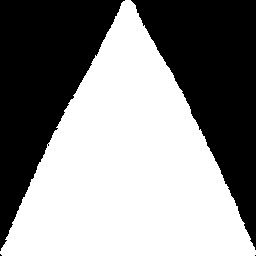
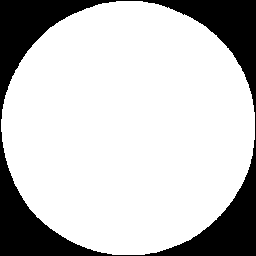

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-pro'}, 'quotaValue': '5'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '36s'}]}}

In [4]:
def run_apply_instruction(row):
    agent.apply_instruction(row["code"],row["instruction"],row["id"])


ds.map(run_apply_instruction)
    